# CS506 Final Project - Predictive Models

### Author: Ania Shaheed

In [265]:
# setup

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Helper Functions

In [284]:
def train_and_eval(X_train, X_test, y_train, y_test):
    results = {}
    
    # Baseline
    baseline = DummyRegressor(strategy='mean')
    baseline.fit(X_train, y_train)
    y_pred = baseline.predict(X_test)
    results['Baseline'] = {'r2': r2_score(y_test, y_pred),
                           'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                           'mae': mean_absolute_error(y_test, y_pred)}
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    results['LinearRegression'] = {'r2': r2_score(y_test, y_pred),
                                   'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                                   'mae': mean_absolute_error(y_test, y_pred)}
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    results['RandomForest'] = {'r2': r2_score(y_test, y_pred),
                               'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                               'mae': mean_absolute_error(y_test, y_pred)}
    
    # XGBoost
    xgb_model = xgb.XGBRegressor(n_estimators=200, random_state=42, verbosity=0)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    results['XGBoost'] = {'r2': r2_score(y_test, y_pred),
                          'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                          'mae': mean_absolute_error(y_test, y_pred)}
    
    return pd.DataFrame(results).T

In [294]:
def pca(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    scaler1 = StandardScaler()
    X_train_s = scaler1.fit_transform(X_train)
    X_test_s = scaler1.transform(X_test)
    
    pca1 = PCA(n_components=0.95, svd_solver = 'full')
    X_train_p = pca1.fit_transform(X_train_s)
    X_test_p = pca1.transform(X_test_s)    

    return X_train_p, X_test_p, y_train, y_test

In [288]:
def plot_model_comparison(results_df, metric = 'r2', title = None):
    plt.figure(figsize = (8,5))
    sns.barplot(x = results_df.index, y = metric, data = results_df.reset_index())
    plt.title(title or f'Model comparison: {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation = 45)
    plt.show()

## Food Access vs. Food Insecurity

1. **Baseline** (DummyRegressor)
- By naively predicting the mean, the model is unable to explain any variance.
- Any model with predictive power is better than the baseline

2. **Linear Regression**
- Explains 68% of variance in food insecurity.
- Good improvement, but may miss nonlinear patterns.

3. **Random Forest**
- Explains 77% of variance.
- Best performing model.
- Captures nonlinear relationships between low-access metrics and food insecurity.

4. **XGBoost**
- Explains 76% variance
- Close performance to random forest
- May improve further with hyperparameter tuning

---
**Summary:**
- Random Forest is the strongest model for Link 1 in this case.
- All models outperform the baseline substantially
- The association between low access and food insecurity is strong and predictable.
- Linear regression gives a good baseline for interpretation, but tree-based methods capture more complexity.

In [255]:
# load data
link1 = pd.read_csv('../data/processed/link1/link1.csv')

In [135]:
list(link1.columns)

['FIPS',
 'State',
 'County, State',
 '2015 Food Insecurity Rate',
 '# of Food Insecure Persons in 2015',
 'Low Threshold in state',
 'Low Threshold Type',
 'High Threshold in state',
 'High Threshold Type',
 '% FI ≤ Low Threshold',
 '% FI Btwn Thresholds',
 '% FI > High Threshold',
 '2015 Child food insecurity rate',
 '# of Food Insecure Children in 2015',
 '% food insecure children in HH w/ HH incomes below 185 FPL in 2015',
 '% food insecure children in HH w/ HH incomes above 185 FPL in 2015',
 '2015 Cost Per Meal',
 '2015 Weighted Annual Food Budget Shortfall',
 'Urban',
 'POP2010',
 'OHU2010',
 'GroupQuartersFlag',
 'NUMGQTRS',
 'LILATracts_1And10',
 'LILATracts_halfAnd10',
 'LILATracts_1And20',
 'LILATracts_Vehicle',
 'HUNVFlag',
 'LowIncomeTracts',
 'LAPOP1_10',
 'LAPOP05_10',
 'LAPOP1_20',
 'LALOWI1_10',
 'LALOWI05_10',
 'LALOWI1_20',
 'lapophalf',
 'lalowihalf',
 'lakidshalf',
 'laseniorshalf',
 'lawhitehalf',
 'lablackhalf',
 'laasianhalf',
 'lanhopihalf',
 'laaianhalf',
 'la

### Testing and Comparing Models

In [296]:
# food access features
X = link1[['Urban', 'POP2010', 'OHU2010', 'GroupQuartersFlag', 'NUMGQTRS', 'LILATracts_1And10', 'LILATracts_halfAnd10', 
     'LILATracts_1And20', 'LILATracts_Vehicle', 'HUNVFlag', 'LowIncomeTracts', 'LAPOP1_10', 'LAPOP05_10', 'LAPOP1_20', 
     'LALOWI1_10', 'LALOWI05_10', 'LALOWI1_20', 'lapophalf', 'lalowihalf', 'lakidshalf', 'laseniorshalf', 'lawhitehalf', 
     'lablackhalf', 'laasianhalf', 'lanhopihalf', 'laaianhalf', 'laomultirhalf', 'lahisphalf', 'lahunvhalf', 'lasnaphalf', 
     'lapop1', 'lalowi1', 'lakids1', 'laseniors1', 'lawhite1', 'lablack1', 'laasian1', 'lanhopi1', 'laaian1', 'laomultir1', 
     'lahisp1', 'lahunv1', 'lasnap1', 'lapop10', 'lalowi10', 'lakids10', 'laseniors10', 'lawhite10', 'lablack10', 'laasian10', 
     'lanhopi10', 'laaian10', 'laomultir10', 'lahisp10', 'lahunv10', 'lasnap10', 'lapop20', 'lalowi20', 'lakids20', 'laseniors20', 
     'lawhite20', 'lablack20', 'laasian20', 'lanhopi20', 'laaian20', 'laomultir20', 'lahisp20', 'lahunv20', 'lasnap20', 'TractLOWI', 
     'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHisp', 
     'TractHUNV', 'TractSNAP', 'LA1and10', 'LAhalfand10', 'LA1and20', 'LATracts_half', 'LATracts1', 'LATracts10', 'LATracts20', 
     'LATractsVehicle_20', 'PCTGQTRS', 'PovertyRate', 'lapophalfshare', 'lalowihalfshare', 'lakidshalfshare', 'laseniorshalfshare', 
     'lawhitehalfshare', 'lablackhalfshare', 'laasianhalfshare', 'lanhopihalfshare', 'laaianhalfshare', 'laomultirhalfshare', 
     'lahisphalfshare', 'lapop1share', 'lalowi1share', 'lakids1share', 'laseniors1share', 'lawhite1share', 'lablack1share', 
     'laasian1share', 'lanhopi1share', 'laaian1share', 'laomultir1share', 'lahisp1share', 'lapop10share', 'lalowi10share', 
     'lakids10share', 'laseniors10share', 'lawhite10share', 'lablack10share', 'laasian10share', 'lanhopi10share', 'laaian10share', 
     'laomultir10share', 'lahisp10share', 'lapop20share', 'lalowi20share', 'lakids20share', 'laseniors20share', 'lawhite20share', 
     'lablack20share', 'laasian20share', 'lanhopi20share', 'laaian20share', 'laomultir20share', 'lahisp20share', 'lahunv20share', 
     'lahunv10share', 'lahunvhalfshare', 'lahunv1share', 'lasnap20share', 'lasnap10share', 'lasnaphalfshare', 'lasnap1share', 
     'MedianFamilyIncome']]

# target var
y = link1['2015 Food Insecurity Rate']

In [298]:
# pca + test train split
X_train_p, X_test_p, y_train, y_test = pca(X, y)

# model and show results
results = train_and_eval(X_train_p, X_test_p, y_train, y_test)
display(results.round(3))

r2   rmse    mae
Baseline         -0.000  0.044  0.033
LinearRegression  0.684  0.025  0.017
RandomForest      0.773  0.021  0.016
XGBoost           0.756  0.022  0.017

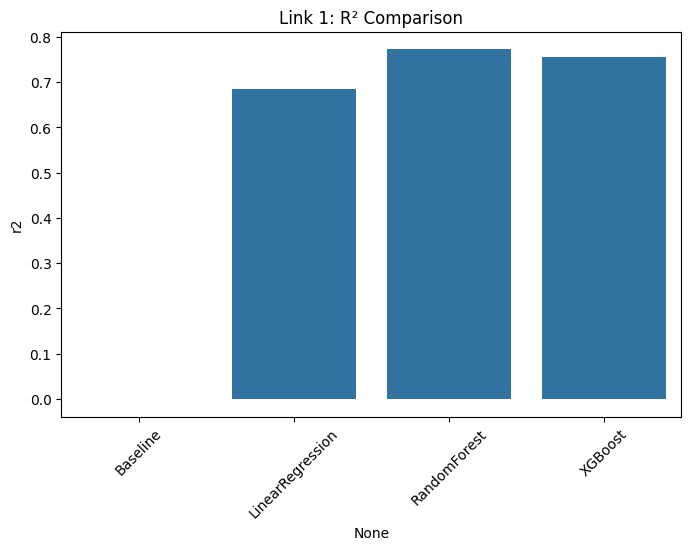

In [300]:
# plot results
plot_model_comparison(results, 'r2', 'Link 1: R² Comparison')

In [187]:
# primary food access features (threshold 1/2 and 10 miles)
x = 'LALOWI05_10'

# potential factors for control
confounders = ['Urban', 'POP2010', 'OHU2010', 'GroupQuartersFlag', 'NUMGQTRS', 'LILATracts_1And10', 'LILATracts_halfAnd10', 
     'LILATracts_1And20', 'LILATracts_Vehicle', 'HUNVFlag', 'LowIncomeTracts', 'LAPOP1_10', 'LAPOP05_10', 'LAPOP1_20', 
     'LALOWI1_10', 'LALOWI1_20', 'lapophalf', 'lalowihalf', 'lakidshalf', 'laseniorshalf', 'lawhitehalf', 
     'lablackhalf', 'laasianhalf', 'lanhopihalf', 'laaianhalf', 'laomultirhalf', 'lahisphalf', 'lahunvhalf', 'lasnaphalf', 
     'lapop1', 'lalowi1', 'lakids1', 'laseniors1', 'lawhite1', 'lablack1', 'laasian1', 'lanhopi1', 'laaian1', 'laomultir1', 
     'lahisp1', 'lahunv1', 'lasnap1', 'lapop10', 'lalowi10', 'lakids10', 'laseniors10', 'lawhite10', 'lablack10', 'laasian10', 
     'lanhopi10', 'laaian10', 'laomultir10', 'lahisp10', 'lahunv10', 'lasnap10', 'lapop20', 'lalowi20', 'lakids20', 'laseniors20', 
     'lawhite20', 'lablack20', 'laasian20', 'lanhopi20', 'laaian20', 'laomultir20', 'lahisp20', 'lahunv20', 'lasnap20', 'TractLOWI', 
     'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHisp', 
     'TractHUNV', 'TractSNAP', 'LA1and10', 'LAhalfand10', 'LA1and20', 'LATracts_half', 'LATracts1', 'LATracts10', 'LATracts20', 
     'LATractsVehicle_20', 'PCTGQTRS', 'PovertyRate', 'lapophalfshare', 'lalowihalfshare', 'lakidshalfshare', 'laseniorshalfshare', 
     'lawhitehalfshare', 'lablackhalfshare', 'laasianhalfshare', 'lanhopihalfshare', 'laaianhalfshare', 'laomultirhalfshare', 
     'lahisphalfshare', 'lapop1share', 'lalowi1share', 'lakids1share', 'laseniors1share', 'lawhite1share', 'lablack1share', 
     'laasian1share', 'lanhopi1share', 'laaian1share', 'laomultir1share', 'lahisp1share', 'lapop10share', 'lalowi10share', 
     'lakids10share', 'laseniors10share', 'lawhite10share', 'lablack10share', 'laasian10share', 'lanhopi10share', 'laaian10share', 
     'laomultir10share', 'lahisp10share', 'lapop20share', 'lalowi20share', 'lakids20share', 'laseniors20share', 'lawhite20share', 
     'lablack20share', 'laasian20share', 'lanhopi20share', 'laaian20share', 'laomultir20share', 'lahisp20share', 'lahunv20share', 
     'lahunv10share', 'lahunvhalfshare', 'lahunv1share', 'lasnap20share', 'lasnap10share', 'lasnaphalfshare', 'lasnap1share', 
     'MedianFamilyIncome']

# target var
y = '2015 Food Insecurity Rate'

In [189]:
corr_X = link1[confounders + [x]].corr()[x].drop(x)
corr_Y = link1[confounders + [y]].corr()[y].drop(y)

corr_df = pd.DataFrame({
    'corr_with_X': corr_X,
    'corr_with_Y': corr_Y
})

# Keep variables correlated with both X and Y (above threshold)
confounders_to_control = corr_df[
    (corr_df['corr_with_X'].abs() > 0.2) &
    (corr_df['corr_with_Y'].abs() > 0.2)
].index.tolist()

corr_df.loc[confounders_to_control]

corr_with_X  corr_with_Y
lawhitehalfshare    -0.289732    -0.393027
lalowi1share        -0.295356     0.486082
lawhite1share       -0.364120    -0.207294
lasnap1share        -0.208681     0.550525

In [205]:
# primary food access features (threshold 1/2 and 10 miles)
x = ['LALOWI05_10']

# selected factors for control at threshold
confounders = [
    'lalowihalfshare', 'lalowi10share',      # low income pop share
    'lasnaphalfshare', 'lasnap10share',       # SNAP participation share
    'lawhitehalfshare', 'lawhite10share',     # % white
    'PovertyRate',                          # economic
    'MedianFamilyIncome',                    # economic
    'Urban',                                 # urbanicity
    'lahunvhalfshare', 'lahunv10share',         # households without vehicles
    'lakidshalfshare', 'lakids10share',         # kids
    'laseniorshalfshare', 'laseniors10share'     # seniors
]

X = x + confounders

# target var
y = '2015 Food Insecurity Rate'

In [207]:
regressions(X, y, link1)

Model        R²      RMSE
0  Linear Regression  0.687714  0.024427
1      Random Forest  0.733547  0.022563
2  Gradient Boosting  0.731369  0.022655

## Food Insecurity vs. Chronic Illness

**Model Performance:**
1. **Baseline** (DummyRegressor)
- No predictive power, any model is better than the baseline

2. **Linear Regression**
- Explains 55% of variance in the health outcome.
- Captures linear association between food insecurity and health outcomes, but misses nonlinear patterns.

3. **Random Forest**
- Explains 64% variance
- Strongest model with lowest RMSE

4. **XGBoost**
- Explain 61% variance

---
**Summary**:
- Random Forest is again the best-performing model, capturing the nonlinear relationships between food insecurity and health outcomes.
- Linear regression still performs reasonably well and provides interpretability.
- Overall, food insecurity explains a moderate amount of variation in chronic health outcomes (R² ~0.55–0.64).
- The predictive strength is lower than Link 1, suggesting other factors beyond food insecurity contribute to health outcomes more.

In [305]:
# load data
link2 = pd.read_csv('../data/processed/link2/link2.csv')

In [307]:
list(link2.columns)

['FIPS',
 'State',
 'County, State',
 '2017 Food Insecurity Rate',
 '# of Food Insecure Persons in 2017',
 'Low Threshold in state',
 'Low Threshold Type',
 'High Threshold in state',
 'High Threshold Type',
 '% FI ≤ Low Threshold',
 '% FI Btwn Thresholds',
 '% FI > High Threshold',
 '2017 Child food insecurity rate',
 '# of Food Insecure Children in 2017',
 '% food insecure children in HH w/ HH incomes below 185 FPL in 2017',
 '% food insecure children in HH w/ HH incomes above 185 FPL in 2017',
 '2017 Cost Per Meal',
 '2017 Weighted Annual Food Budget Shortfall',
 'TotalPopulation',
 'ACCESS2_CrudePrev',
 'ACCESS2_Crude95CI',
 'ACCESS2_AdjPrev',
 'ACCESS2_Adj95CI',
 'ARTHRITIS_CrudePrev',
 'ARTHRITIS_Crude95CI',
 'ARTHRITIS_AdjPrev',
 'ARTHRITIS_Adj95CI',
 'BINGE_CrudePrev',
 'BINGE_Crude95CI',
 'BINGE_AdjPrev',
 'BINGE_Adj95CI',
 'BPHIGH_CrudePrev',
 'BPHIGH_Crude95CI',
 'BPHIGH_AdjPrev',
 'BPHIGH_Adj95CI',
 'BPMED_CrudePrev',
 'BPMED_Crude95CI',
 'BPMED_AdjPrev',
 'BPMED_Adj95CI',


In [329]:
link2['TotalPopulation'] = link2['TotalPopulation'].str.replace(',', '').astype(int)

### Testing and Comparing Models

In [339]:
# food insecurity features
X = link2[['2017 Food Insecurity Rate', '# of Food Insecure Persons in 2017', 'Low Threshold in state', 
          'High Threshold in state', '% FI ≤ Low Threshold', 
          '% FI > High Threshold', '2017 Child food insecurity rate', 
          '# of Food Insecure Children in 2017', '% food insecure children in HH w/ HH incomes below 185 FPL in 2017', 
          '% food insecure children in HH w/ HH incomes above 185 FPL in 2017', '2017 Cost Per Meal', 
          '2017 Weighted Annual Food Budget Shortfall', 'TotalPopulation']] 

# target var
y = link2['Chronic_CrudePrev_Mean']

In [343]:
# pca + test train split
X_train_p, X_test_p, y_train, y_test = pca(X, y)

# model and show results
results = train_and_eval(X_train_p, X_test_p, y_train, y_test)
display(results.round(3))

r2   rmse    mae
Baseline         -0.009  2.232  1.767
LinearRegression  0.546  1.497  1.138
RandomForest      0.637  1.339  1.020
XGBoost           0.613  1.381  1.053

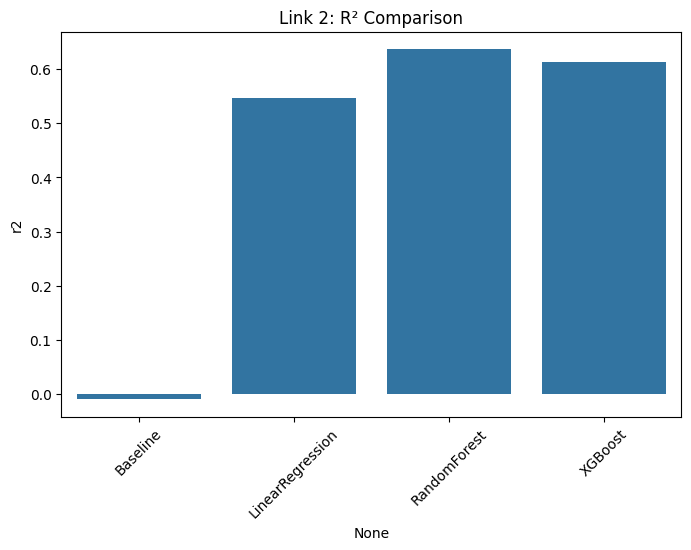

In [347]:
# plot results
plot_model_comparison(results, 'r2', 'Link 2: R² Comparison')

### Extracting Indicators